In [1]:
import re
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
%matplotlib inline

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation as LDA

import warnings
warnings.filterwarnings('ignore')

In [2]:
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from wordcloud import WordCloud

In [3]:
stop_words = set(stopwords.words("english"))        

In [4]:
raw_df = pd.read_csv("Diabetes Journal Abstracts.csv")
print(raw_df.shape)
raw_df.head(3)

(16313, 2)


,YearPubmed,AbstractText
0,2016,INTRODUCTION: Type 1 Diabetes Mellitus (T1DM) ...
1,2016,The study was aimed at finding the effect of g...
2,2016,OBJECTIVE: To explore the relationships of the...


In [5]:
#lower case all the words in 'AbstractText' and only keep a-z letters and 0-9 numbers.
#remove all other special signs like &%$#... and punctuations.
raw_df["text_lower"] = raw_df.AbstractText.apply(lambda text: re.sub('[^a-z0-9]+', ' ', text.lower()))
raw_df.head(3)

,YearPubmed,AbstractText,text_lower
0,2016,INTRODUCTION: Type 1 Diabetes Mellitus (T1DM) ...,introduction type 1 diabetes mellitus t1dm and...
1,2016,The study was aimed at finding the effect of g...,the study was aimed at finding the effect of g...
2,2016,OBJECTIVE: To explore the relationships of the...,objective to explore the relationships of the ...


In [6]:
raw_df.iloc[2,2]

'objective to explore the relationships of the expression of mir 145 to the clinicopathological characteristics and prognosis of patients with breast cancer complicated by type 2 diabetes mellitus t2dm methods a total of 257 female patients with breast cancer were enrolled for our experiment including 140 patients with simple breast cancer control group and 117 patients with breast cancer complicated by t2dm observation group patients were treated with modified radical mastectomy supplemented with radiotherapy chemotherapy and endocrine therapy qrt pcr was used for the detection of mir 145 expression in patients of both groups follow up lasted 13 60 months results the relative expression of mir 145 in the observation group was significantly lower than that in the control group p amp lt 0 05 the expression of mir 145 in patients with breast cancer complicated by t2dm was related to the history of diabetes tumor node metastasis tnm stage tumor size lymph node metastasis lnm estrogen rece

In [7]:
porter = PorterStemmer() # get the root word

def parseText(text):
    
    # remove special characters and change to lower case, then split the texts. 
    text_tokens = text.split(' ')
    
    res_tokens = []
    
    # remove the token is empty or single token 
    for token in text_tokens:
        if len(token.strip()) > 1:
            # token = porter.stem(token.strip())  # get the root word for the token
            token = token.strip()
            if not token.isdigit():
                if len(token) > 1 and token not in stop_words:
                    res_tokens.append(token)
    
    return ' '.join(res_tokens)
                    

In [8]:
raw_df["text_cleaned"] = raw_df.text_lower.apply(parseText)

In [9]:
raw_df.head()

,YearPubmed,AbstractText,text_lower,text_cleaned
0,2016,INTRODUCTION: Type 1 Diabetes Mellitus (T1DM) ...,introduction type 1 diabetes mellitus t1dm and...,introduction type diabetes mellitus t1dm psych...
1,2016,The study was aimed at finding the effect of g...,the study was aimed at finding the effect of g...,study aimed finding effect garlic resveratrol ...
2,2016,OBJECTIVE: To explore the relationships of the...,objective to explore the relationships of the ...,objective explore relationships expression mir...
3,2016,BACKGROUND: Preterm birth is the major cause o...,background preterm birth is the major cause of...,background preterm birth major cause perinatal...
4,2016,BACKGROUND: This study was designed to determi...,background this study was designed to determin...,background study designed determine diagnostic...


## check the word cloud

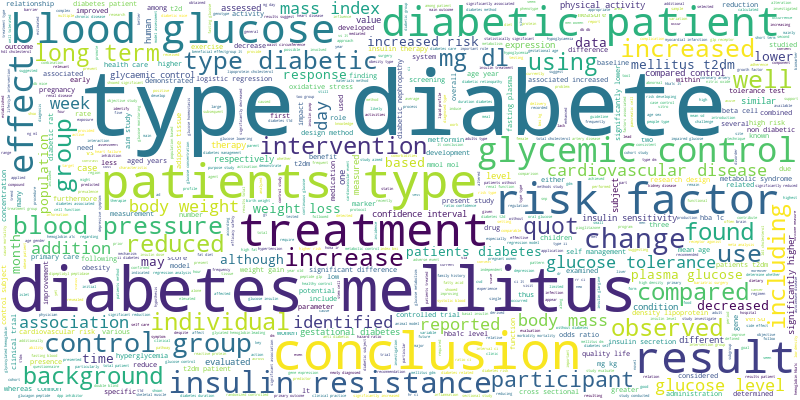

In [10]:
# join all the text together
#long_string = ','.join(list(raw_df['text_cleaned'].values))
long_string = ' '.join(list(raw_df['text_cleaned'].values))
# Create a WordCloud object
wordcloud = WordCloud(background_color="white", max_words=5000, width=800, height=400,contour_width=3, contour_color='steelblue')

# Generate a word cloud
wordcloud.generate(long_string)

# Visualize the word cloud
wordcloud.to_image()


The Word cloud of the meaningful words shows the word 'diabetes','type','treatment', etc. have very high frequency, so we can guess that most of the abstracts are about the treatment of different type of diabetes. 

# build LDA model

In [11]:
# create a document-word matrix
                                                                
count_vectorizer = CountVectorizer(min_df = 0.1, max_df = 0.8, #the min and max limit of document frequency
                                   stop_words='english', max_features = 10000)
count_data = count_vectorizer.fit_transform(raw_df["text_cleaned"])

In [12]:
def plot_most_common_words(count_data, count_vectorizer, top_n = 20):
    words = count_vectorizer.get_feature_names()
    total_counts = np.zeros(len(words))
    for t in count_data:
        total_counts += t.toarray()[0]
    
    count_dict = (zip(words, total_counts))
    count_dict = sorted(count_dict, key=lambda x:x[1], reverse=True)[0:top_n] 
    words = [w[0] for w in count_dict]
    counts = [w[1] for w in count_dict]
    x_pos = np.arange(len(words)) 
    
    plt.figure(2, figsize=(10, 7))
    plt.subplot(title='{} most common words'.format(top_n))
    sns.set_context("notebook", font_scale=3, rc={"lines.linewidth": 2.5})
    sns.barplot(x_pos, counts, palette='husl')
    plt.xticks(x_pos, words, rotation=45) 
    plt.xlabel('words')
    plt.ylabel('counts')
    plt.show()

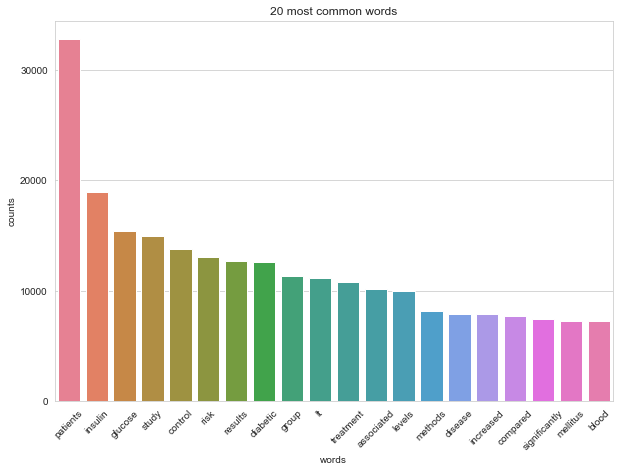

In [13]:
plot_most_common_words(count_data, count_vectorizer)

The frequency of the 20 most common meaningful words shows ‘patients’ is the common word with highest frequency, then ‘insulin’, ‘glucose’, ‘study’, ‘control’, ‘risk’, ‘results’, ‘diabetic’,…  

Based on the frequency of common words, we can guess most of the abstracts are about research of the treatment on insulin and glucose on patients with diabetes.  

After getting to know the overall picture of the abstracts, I use Latent Dirichlet Allocation (LDA) topic modeling technique on the abstract, and find the probabilities of different topics were included in the abstract. 

In [14]:
number_topics = 4

In [15]:
lda = LDA(n_components=number_topics, n_jobs=-1)
lda.fit(count_data)

LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
             evaluate_every=-1, learning_decay=0.7,
             learning_method='batch', learning_offset=10.0,
             max_doc_update_iter=100, max_iter=10, mean_change_tol=0.001,
             n_components=4, n_jobs=-1, n_topics=None, perp_tol=0.1,
             random_state=None, topic_word_prior=None,
             total_samples=1000000.0, verbose=0)

In [16]:
#Top 20 words in the 4 topics
words = count_vectorizer.get_feature_names()
n_top_words = 20

print("Topics found via LDA:")
for topic_idx, topic in enumerate(lda.components_):
    print("\nTopic #%d:" % topic_idx)
    print(" ".join([words[i]
                    for i in topic.argsort()[:-n_top_words - 1:-1]]))

Topics found via LDA:

Topic #0:
group patients diabetic lt levels control significantly glucose study groups compared subjects results mg vs blood significant plasma higher weeks

Topic #1:
insulin glucose cells cell effects obesity metabolic diabetic treatment increased induced resistance disease activity associated protein studies function levels development

Topic #2:
risk patients study associated ci care health women results disease years age factors methods data association analysis cardiovascular outcomes using

Topic #3:
patients insulin t2dm treatment therapy glucose control hba1c glycemic clinical study results weight mellitus patient mean blood years use data


# view model result

In [17]:
import pyLDAvis
from pyLDAvis import sklearn as ldask
pyLDAvis.enable_notebook() #enable automatic D3 display of prepared model data in notebook
panel = ldask.prepare(lda, count_data, count_vectorizer, mds='tsne')
panel


PreparedData(topic_coordinates=                x           y  topics  cluster       Freq
topic                                                    
2     -375.441895 -182.389282       1        1  32.137124
0      257.651764  133.081406       2        1  28.537631
1      572.793457 -500.178040       3        1  19.709390
3      -60.303600 -815.645203       4        1  19.615855, topic_info=    Category          Freq        Term         Total  loglift  logprob
61   Default  19018.000000     insulin  19018.000000  30.0000  30.0000
46   Default  11417.000000       group  11417.000000  29.0000  29.0000
86   Default  32790.000000    patients  32790.000000  28.0000  28.0000
116  Default   6471.000000        t2dm   6471.000000  27.0000  27.0000
106  Default  12933.000000        risk  12933.000000  26.0000  26.0000
15   Default   5105.000000       cells   5105.000000  25.0000  25.0000
14   Default   4503.000000        cell   4503.000000  24.0000  24.0000
44   Default  15506.000000     glucose  15506.000000  23.0000  23.0000
30   Default  12622.000000    diabetic  12622.000000  22.0000  22.0000
118  Default   5445.000000     therapy   5445.000000  21.0000  21.0000
18   Default   5881.000000          ci   5881.000000  20.0000  20.0000
122  Default  10785.000000   treatment  10785.000000  19.0000  19.0000
63   Default  10037.000000      levels  10037.000000  18.0000  18.0000
13   Default   5669.000000        care   5669.000000  17.0000  17.0000
129  Default   5467.000000       women   5467.000000  16.0000  16.0000
80   Default   3996.000000     obesity   3996.000000  15.0000  15.0000
67   Default  11198.000000          lt  11198.000000  14.0000  14.0000
49   Default   5611.000000      health   5611.000000  13.0000  13.0000
60   Default   3239.000000     induced   3239.000000  12.0000  12.0000
48   Default   6045.000000       hba1c   6045.000000  11.0000  11.0000
73   Default   4400.000000   metabolic   4400.000000  10.0000  10.0000
47   Default   5727.000000      groups   5727.000000   9.0000   9.0000
33   Default   7885.000000     disease   7885.000000   8.0000   8.0000
102  Default   3133.000000  resistance   3133.000000   7.0000   7.0000
45   Default   3851.000000    glycemic   3851.000000   6.0000   6.0000
75   Default   4981.000000          mg   4981.000000   5.0000   5.0000
35   Default   5580.000000     effects   5580.000000   4.0000   4.0000
93   Default   3170.000000     protein   3170.000000   3.0000   3.0000
85   Default   3840.000000     patient   3840.000000   2.0000   2.0000
0    Default   3435.000000    activity   3435.000000   1.0000   1.0000
..       ...           ...         ...           ...      ...      ...
123   Topic4   1790.637893         use   3976.421635   0.8310  -4.2740
77    Topic4   1524.460464      months   3401.689883   0.8262  -4.4349
19    Topic4   2736.355882    clinical   6208.754202   0.8095  -3.8499
70    Topic4   2065.858816        mean   4879.325982   0.7694  -4.1310
128   Topic4   2424.697948      weight   5813.060669   0.7544  -3.9709
130   Topic4   1115.861256        year   2724.204797   0.7363  -4.7469
64    Topic4    945.581425        long   2350.697261   0.7182  -4.9125
86    Topic4  12821.103625    patients  32790.958694   0.6898  -2.3055
119   Topic4   1329.301553        time   3468.663012   0.6697  -4.5719
97    Topic4    913.160414   reduction   2396.355433   0.6640  -4.9474
9     Topic4   1446.640337    baseline   3806.922300   0.6613  -4.4873
121   Topic4   1096.223306     treated   3252.182228   0.5414  -4.7647
100   Topic4    790.526797    reported   2599.911208   0.4383  -5.0916
72    Topic4   2169.611764    mellitus   7248.979063   0.4225  -4.0820
44    Topic4   4479.367279     glucose  15506.715742   0.3870  -3.3571
55    Topic4    851.314995    included   2968.529972   0.3798  -5.0175
54    Topic4    649.343304    improved   2284.424571   0.3709  -5.2884
26    Topic4   1660.204535        data   5875.700641   0.3649  -4.3496
8     Topic4   1060.090757       based   3880.713960   0.33

Based on the topic (you could change the number of topic to see the difference of the result), there are several major topic: 
    1. fundamental research in the cell level (group 3)
    2. clinical research for different associated risks (group 2)
    3. clinical treatment research for diabetic for women(??) (group 4)
    4. research regarding to the diabetic for different group of people including age etc (group 1)
    
Some of the groups having mutual important keywords, which means those groups could merge together. For clustering, it is unsupervised learning, and no labels. How many topics really depends on the user. 

Based on the keywords, there are four major topics: 

 

group_1:  Clinical study of control and treatment on Hba1c results in diabetes patients 

group_2:  Age and obesity are associated with diabetic disease in Cardiovascular studies on women 

group_3:  Fasting and control treatment on insulin and glucose level in the blood of diabetic patient. 

group_4:  Control and treatment on the function and activities of proteins in the cells of diabetes patient. 

Some of the groups having mutual important keywords, which means those groups could merge together. For clustering, it is unsupervised learning, and no labels. The number of topics really depends on the user. 